# Spurious-Free Dynamic Range (SFDR), Teil 2 #

Im zweiten Teil geht es um Beispiele für SFDR, also den Abstand zwischen dem Nutzsignal und den stärksten Störamplituden in einem Frequenzspektrum.

Im Buch *Software Defined Radio for Engineers*, das man [hier](https://www.analog.com/en/education/education-library/software-defined-radio-for-engineers.html) angucken kann, und im zugehörigen [Github-Repository](https://github.com/sdrforengineers) findet man zu Kapitel 2.5.5 die Skripts *sfdr_example.m* und *sfdr_test.m*.



In [26]:
def sfdr(x,fs): # attempt of a python version of MATLABs sfdr function 
    xw = x * np.kaiser(len(x),beta=38) /len(x)
    xw -= np.mean(xw)
    Y = np.fft.rfft(xw)
    freqs = np.fft.rfftfreq(len(xw), d=1.0/fs)
    mag = np.abs(Y)
    YdB = 20 * np.log10(mag)
    peakind = signal.find_peaks(YdB, distance = 5)
    pksf=freqs[peakind[0]]
    pksY=YdB[peakind[0]]
    isorted = np.argsort(pksY)
    sfdrval = pksY[isorted[-1]] - pksY[isorted[-2]]
    fig, ax = plt.subplots()
    #ax = plt.gca()
    pkfa = pksf[isorted[-1]]
    pkYa = pksY[isorted[-1]]
    pkfb = pksf[isorted[-2]]
    pkYb = pksY[isorted[-2]]
    plt.fill_between((0,fs/2),(pkYb,pkYb),(pkYa,pkYa), label = 'SFDR',
                     color = "lightblue")    
    ax.plot(pkfa, pkYa, marker="s", label = 'fundamental')
    ax.plot(pkfb, pkYb, marker="s", label = 'spurs')
    ax.plot(freqs, YdB)
    ax.set(xlabel = 'Frequency (Hz)', ylabel = 'Power (dB)',
           title = "SFDR %.2f dB" % sfdrval)
    ax.set_xlim(0, fs / 2)
    ax.set_ylim(-400, 10)    
    ax.legend(loc = "upper right")
    return sfdrval

## Beispiel 1: ##

Das 1. Beispiel verwendet double-precision-Fließkommazahlen.
Die verwendete Signalfrequenz, 3,959297 MHz und die Abtastrate (100 MHz) stehen in keinem ganzzahligen Verhältnis zueinander.
Mit diesen Vorgaben erhält man einen riesigen SFDR-Wert, nämlich ungefähr 289 dB (siehe auch Figure 2.28 im Buch), den man mit echter Hardware natürlich nie erreichen kann

289.49027533107375

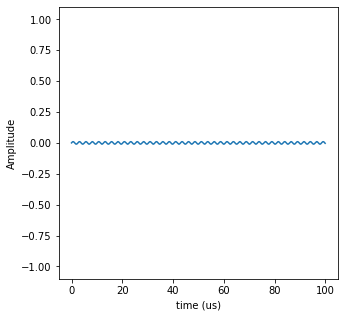

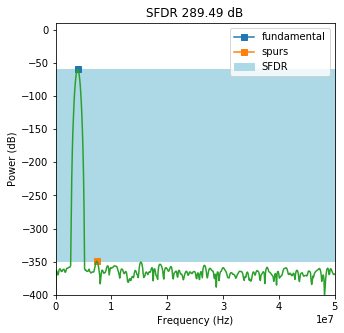

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]
import numpy as np
from scipy import signal

deltat = 1e-8
fs = 1/deltat
t = np.arange(0, 1e-5-deltat, deltat)
fundamental=3959297
x = 10e-3*np.sin(2*np.pi*fundamental*t)

fig, ax = plt.subplots()
ax.plot(t*10e6,x)
ax.set_xlabel('time (us)')
ax.set_ylabel('Amplitude')
ax.set_ylim((-1.1, 1.1))

sfdr(x, fs)

## Beispiel 2: ##

In der Realität wird oft ein vorzeichenbehaftetes Festkommaformat benutzt, das hier im 2. Beispiel auch angewendet wird.
In diesem Beispiel werden 11 bit für die Amplitude und 1 bit für das Vorzeichen verwendet.

Im folgenden Code-Schnipsel wird deswegen das Signal mit 2^11 multipliziert, gerundet und dann auf den Wertebereich von -1 bis +1 herunterskaliert. Das ergibt ein SFDR von ~46 dB, was weniger als 8 bit entsprechen würde.
Das liegt aber daran, dass das Signal mit 10e-3 vor der Rundung herunterskaliert wurde.

45.81463603889045

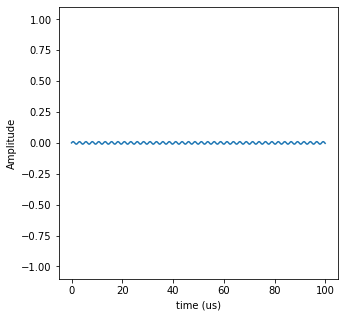

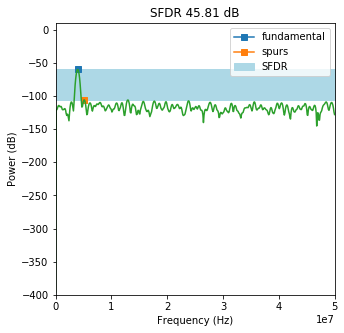

In [28]:
bits=2**11
x = np.round(10e-3*bits*np.sin(2*np.pi*fundamental*t))/bits

fig, ax = plt.subplots()
ax.plot(t*10e6,x)
ax.set_xlabel('time (us)')
ax.set_ylabel('Amplitude')
ax.set_ylim((-1.1, 1.1))

sfdr(x, fs)

## Beispiel 3: ##

Läßt man das Herunterskalieren vor dem Runden bleiben, dann wird der volle Wertebereich einer 12-bit-Zahl genutzt (siehe Figure 2.30(a) im Buch). Der SFDR-Wert erreicht ~88 dB.

88.43609956655592

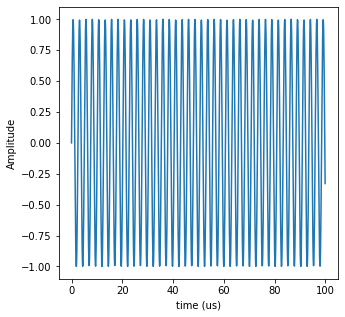

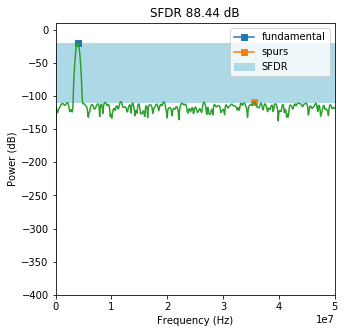

In [29]:
bits=2**11
x = np.round(bits*np.sin(2*np.pi*fundamental*t))/bits

fig, ax = plt.subplots()
ax.plot(t*10e6,x)
ax.set_xlabel('time (us)')
ax.set_ylabel('Amplitude')
ax.set_ylim((-1.1, 1.1))

sfdr(x, fs)

## Beispiel 4: ##

Um das Ergebnis für den SFDR-Wert vom vorigen Beispiel weiter zu verbessern, kann man den ""FFT processing gain" nutzen.
Dazu wird lediglich die Anzahl von Abtastwerten erhöht, in dem man einen längeren (10000) Block von Abtastwerten erzeugt.
Das Ergebnis ist ein SFDR-Wert von ~94 dBc (siehe Figure 2.30(b) im Buch).
Durch die höhere Anzahl von Abtastwerten wird auch die Anzahl der Frequenz-Bins größer und dadurch reduziert sich die Energie in jedem dieser Frequenz-Bins.

94.46882780024455

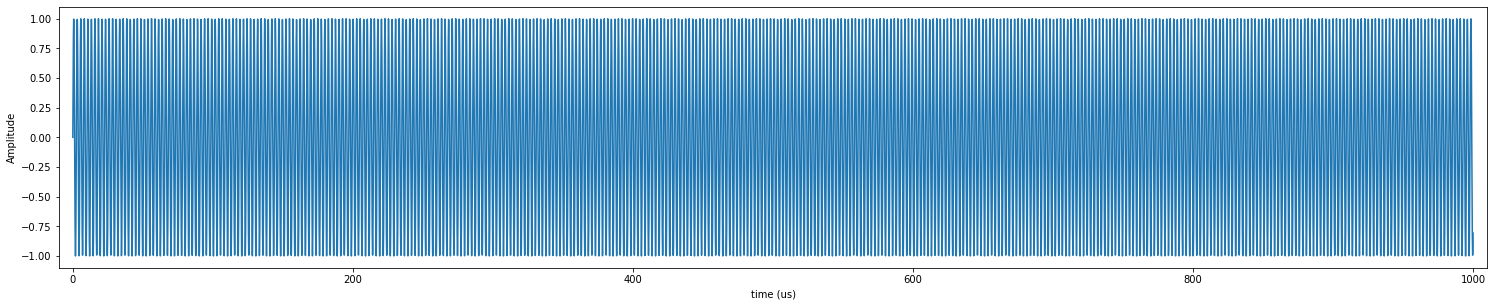

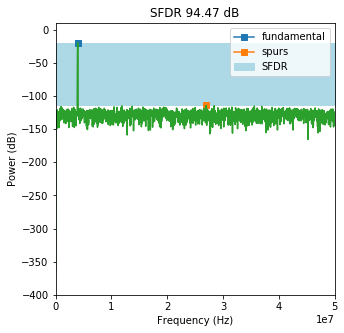

In [30]:
t = np.arange(0, 1e-4-deltat, deltat)
x = np.round(bits*np.sin(2*np.pi*fundamental*t))/bits

fig, ax = plt.subplots(figsize = [25.6, 4.8])
ax.plot(t*10e6,x)
ax.set_xlabel('time (us)')
ax.set_ylabel('Amplitude')
ax.set_ylim((-1.1, 1.1))
ax.set_xlim((-10, 1010))

sfdr(x, fs)

## Beispiel 5: ##

Bisher wurde als Signalfrequenz 3,959297 MHz verwendet.
Was passiert, wenn die Abtastfrequenz und die Signalfrequenz miteinander korreliert sind?
Zu diesem Zweck wird die Signalfrequenz auf genau 4 MHz hochgedreht.
Das Ergebnis sieht man im folgenden Diagramm.

Der SFDR-Wert ist um etwa 12 db schlechter als vorher!

82.75447744467012

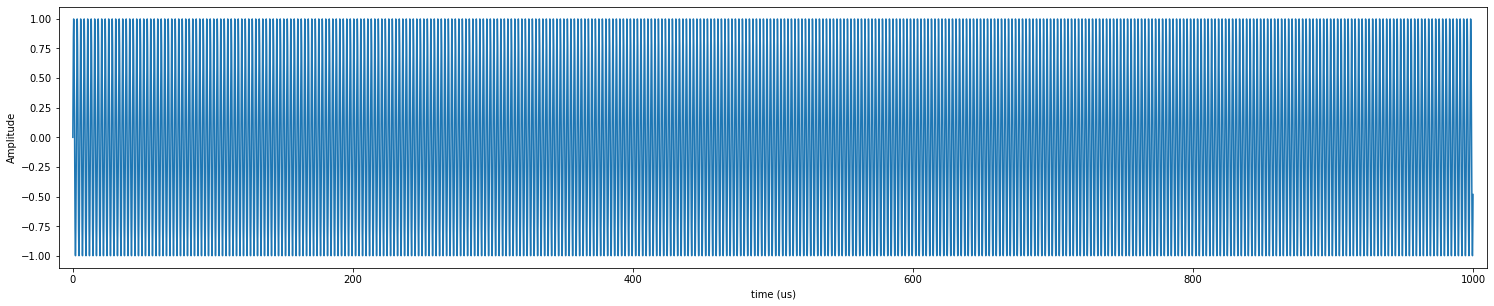

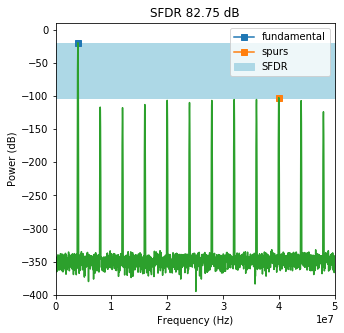

In [32]:
fundamental=4000000
x = np.round(bits*np.sin(2*np.pi*fundamental*t))/bits

fig, ax = plt.subplots(figsize = [25.6, 4.8])
ax.plot(t*10e6,x)
ax.set_xlabel('time (us)')
ax.set_ylabel('Amplitude')
ax.set_ylim((-1.1, 1.1))
ax.set_xlim((-10, 1010))

sfdr(x, fs)

## Beispiel 6: ##

Um den Verlust zu vorher wiedergutzumachen, benutzt man eine Technik namens _dithering_ (siehe Figure 2.31(b) im Buch).
Dadurch wird die Energie, die sich auf einzelne Harmonische konzentriert hat, auf den gesamten Rauschuntergrund verteilt.
Dadurch erhöht sich zwar der gesamte Rauschuntergrund, aber die Energie in den höchsten Störlinien wird deutlich kleiner.

Das Resultat sieht man im nächsten Plot.
Der hier verwendete _dithering_ -Algorithmus addiert oder subtrahiert nach dem Zufallsprinzip den Wert 0.5 zu bzw. von jedem Abtastwert, bevor dieser gerundet wird. Der Effekt ist also, dass jeder Abtastwert nach dem Zufallsprinzip ab- oder aufgerundet wird.

95.581162053116

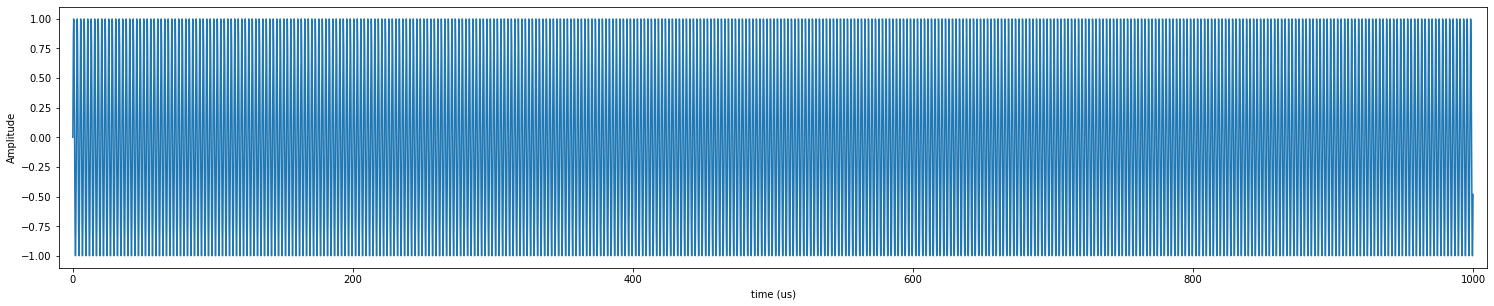

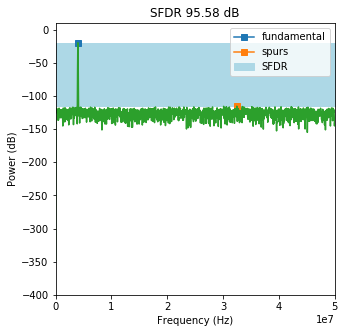

In [35]:
ran = np.random.rand(len(t)) - 0.5
x = np.round(bits*np.sin(2*np.pi*fundamental*t) + ran)/bits

fig, ax = plt.subplots(figsize = [25.6, 4.8])
ax.plot(t*10e6,x)
ax.set_xlabel('time (us)')
ax.set_ylabel('Amplitude')
ax.set_ylim((-1.1, 1.1))
ax.set_xlim((-10, 1010))

sfdr(x, fs)